In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
%matplotlib inline
sns.set_style('dark')

#import libraries for statistical analysis
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


#import libraries for parallel processing
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

#import custom utils including persistence testbench
from model_persistence import get_persistence_dataset, train_test_split, walk_forward_evaluation, calculate_errors, plot_error
from create_day_types import get_days_dummies

## ARIMA Models

ARIMA stands for Autoregressive Integrated Moving Average. It uses a linear combination of past time steps, and moving averages to predict t.

## Contents 
1. ARIMA parameters analysis
2. ARIMA multi-step training and evaluation


#### ARIMA Models Evaluated
1. Multi-step output for ARIMA


ARIMA takes only a stationary time series.

We will use the ARIMA model from statsmodels.api which takes the following arguments:
- p: is the number of lag observations in the model and can be estimated from Autocorrelation plots
- d: the number of times raw observations are differenced in order to make the series stationary. This is determined with a Dicky-Fuller test.
- q: the side of the moving average window. The order of moving average.

In [2]:
#load the dataset and create the train and test sets.
data = get_persistence_dataset(transformed=True)

#split using default date 2017-12-31
train, test = train_test_split(data)
train.head(3)

Train start and stop dates 2015-01-01 00:00:00 2017-12-31 00:00:00
Test start and stop dates 2018-01-01 00:00:00 2018-12-31 00:00:00


,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,...,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,...,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0
2015-01-03,25564.0,23584.0,22194.0,21296.0,21145.0,21316.0,21674.0,22127.0,22756.0,24654.0,...,26416.0,25362.0,24770.0,24501.0,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0


In [3]:
train.index.min(), train.index.max(),test.index.min(), test.index.max()

(Timestamp('2015-01-01 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-12-31 00:00:00'))

##### Stationary and Differencing of the dataset

Set of daily mean data was stationary over the course of a year. Here we test if the hourly data is stationary using the Adfuller Test over a period of 24 hrs, 1 week and a month of lags (24 * 7).

***Null Hypothesis***: The dataset is non-stationary and therefore differencing must be carried out.

If p-value is < 0.05 (two tailed test), we reject the null and assume that the time series is stationary.

In [4]:
#flatten the train set because the statistical model only accepts univariate series
train_flat = train.values.flatten()

Stationary test over **1 day.**

In [5]:
adful_t = sm.tsa.adfuller(train_flat, maxlag=24)
print(pd.Series(adful_t[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic      -27.582837
p-value               0.000000
#Lags                24.000000
Observations      26279.000000
dtype: float64


Stationary test over **1 week.**

In [7]:
adful_t = sm.tsa.adfuller(train_flat, maxlag=24*7)
print(pd.Series(adful_t[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic   -7.804579e+00
p-value           7.339533e-12
#Lags             1.680000e+02
Observations      2.613500e+04
dtype: float64


Stationary test over **1 month**.

In [8]:
adful_t = sm.tsa.adfuller(train_flat, maxlag=24*30)
print(pd.Series(adful_t[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic       -4.354917
p-value               0.000356
#Lags               720.000000
Observations      25583.000000
dtype: float64


All p-values for different time intervals are significantly >0.05. Therefore, can reject the null hypothesis that series is non-stationary and that differencing is needed. So differencing will not be needed. It is assumed that the dataset is stationary.

Therefore the default model parameter for d (the differncing value) is 0. We will also invesitgate a differencing parameter of 24 and 168 corresponding with the previous day, and the previous week.

##### Autocorrelation and partial autocorrelation

Description of the plots:

ACF - Describes the direct and indirect relationships between lagging (shifted) autoregressive features. I.e. the relationships between t, t-1, t-2, t-3 etc. taking into account the interrelatinships between features, in this case t-1 and t-2, t-2 and t-3 etc.

PACF - Describes only the direct relationships between lagging (shifted) and autoregressive features.

p (AR): Determining the autoregressive hyperparameter value p, is best described as the number of lags beyond which there is no significant relationship. This is seen in the ACF as the point at which plot values lie outside the significance band (light blue horizontal band)

q (MR): Determining the moving average hyperparameter value q, is described as the direct relationship with the lag feature and the feature.

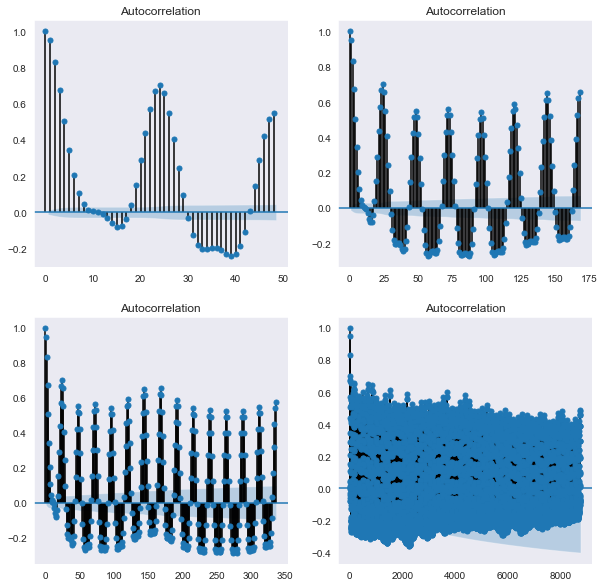

In [9]:
#plot the ACF with lags of: 2 days, 1 wk, 2 wks and 1 yr
fig, axs = plt.subplots(2,2, figsize=(10,10))

lags = [48, 24*7, 24*14, 24*365]

for lag, ax in zip(lags, axs.flatten()):
    plot_acf(train_flat, lags=lag, ax=ax)
plt.show()

Graph Interpretations:

The autocorrelation plot shows significant positive corelations in the first 9 lags. However in this problem we are attempting to forecast the next 24 hours and using a lag less than 24 does not capture the full context of a short-term day ahead forecast.

The cyclic pattern of the autoregressive features is apprent in the plots. In the ARIMA model the assumption is that beyond the chosen lag point (p), there is no correlation. Observing the bottom right plot we see this point occurs around approximately 4000 lags (approximately 1/2 year).

For the scope of this project calculating with 4000 lags is not feasible. We will focus on lag points 24 (previous day), 48 (previous two days), 168 (previous week).

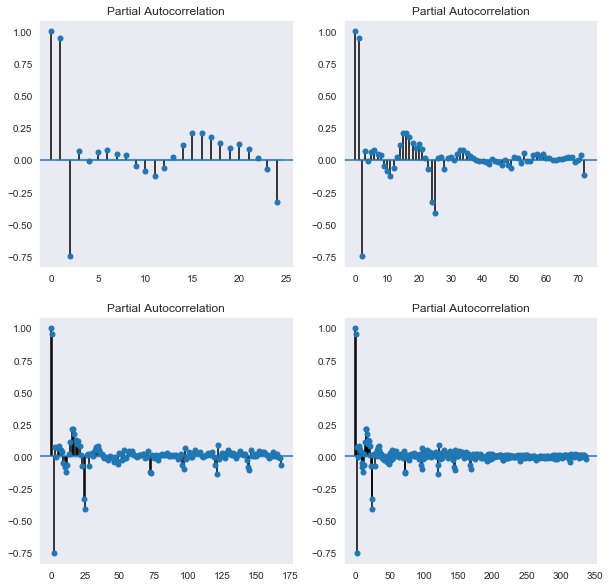

In [10]:
#plot the ACF with lags of: 1 day, 3 days, 1 wk and 2 wks
fig, axs = plt.subplots(2,2, figsize=(10,10))

lags = [24, 24*3, 24*7, 24*14]

for lag, ax in zip(lags, axs.flatten()):
    plot_pacf(train_flat, lags=lag, ax=ax)
plt.show()

### ARIMA Model: Baselines

The baseline parametres for the ARIMA model are chosen as (p, d, q) = (24, 0, 0). This implies 24 autoregressive features are computed for each day in the training set. Because this is computationally intensive we will run this for 1/365 test cycle of the walk forward validation and log the training time.

In [12]:
#Seeing how long it would take to implement 1 forecasting pd to estimate run time on a larger scale

def test_run_ARIMA(train_flat):
    #setup a model instence
    model_24 = ARIMA(train_flat, order=(24, 0, 0))

    #fit the model
    model_fit_24 = model_24.fit()

    #run the 24 interval forecast and return the operation time
    forecast_24, std_24, intervals_24 = model_fit_24.forecast(24)
    
    return forecast_24, std_24, intervals_24
    
%time forecast_24, std_24, intervals_24 = test_run_ARIMA(train_flat)    

CPU times: user 34min 30s, sys: 15.7 s, total: 34min 46s
Wall time: 18min 37s
